In [7]:
from datasets import load_dataset
import pandas as pd
import re

# Load Hugging Face Dataset
dataset = load_dataset("starvector/text2svg-stack")
df = dataset["train"].to_pandas()

# Filter top 100000 SVGs by length
df["svg_length"] = df["Svg"].apply(len)
df_sorted = df.sort_values("svg_length", ascending=False).head(100_000).copy()

# Extract width and height from SVG tag
def extract_svg_dims(svg_str):
    match = re.search(r'<svg[^>]*width="(\d+)"[^>]*height="(\d+)"', svg_str)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))
        return width, height
    return None, None

df_sorted["svg_dims"] = df_sorted["Svg"].apply(extract_svg_dims)
df_filtered = df_sorted[df_sorted["svg_dims"].apply(
    lambda dims: dims[0] is not None and 800 <= dims[0] <= 1000 and 800 <= dims[1] <= 1000
)].copy()

# Extract input and target text
input_texts = df_filtered["caption_blip2"].astype(str).tolist()
target_svgs = df_filtered["Svg"].astype(str).tolist()

In [8]:
len(df_filtered)

851

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch.optim as optim

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Custom Dataset class
class TextToSVGDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=512):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        input_enc = self.tokenizer(input_text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        target_enc = self.tokenizer(target_text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }

# Dataset and Dataloader
dataset = TextToSVGDataset(input_texts, target_svgs, tokenizer)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Load model and set device
model = T5ForConditionalGeneration.from_pretrained("t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training function
def train(model, dataloader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        print(f"\n✅ Epoch {epoch+1} Completed. Average Loss: {total_loss / len(dataloader):.4f}\n")

# Train the model
train(model, dataloader, optimizer, epochs=5)

Epoch 1, Batch 0, Loss: 13.5094
Epoch 1, Batch 10, Loss: 5.0926
Epoch 1, Batch 20, Loss: 4.6203
Epoch 1, Batch 30, Loss: 4.3746
Epoch 1, Batch 40, Loss: 4.2513
Epoch 1, Batch 50, Loss: 4.2489
Epoch 1, Batch 60, Loss: 3.8603
Epoch 1, Batch 70, Loss: 4.0450
Epoch 1, Batch 80, Loss: 3.8581
Epoch 1, Batch 90, Loss: 3.7225
Epoch 1, Batch 100, Loss: 3.5474
Epoch 1, Batch 110, Loss: 3.4119
Epoch 1, Batch 120, Loss: 3.2775
Epoch 1, Batch 130, Loss: 3.5863
Epoch 1, Batch 140, Loss: 2.9175
Epoch 1, Batch 150, Loss: 3.1210
Epoch 1, Batch 160, Loss: 3.0543
Epoch 1, Batch 170, Loss: 2.7500

✅ Epoch 1 Completed. Average Loss: 3.9726

Epoch 2, Batch 0, Loss: 3.3680
Epoch 2, Batch 10, Loss: 2.9693
Epoch 2, Batch 20, Loss: 2.7083
Epoch 2, Batch 30, Loss: 2.6389
Epoch 2, Batch 40, Loss: 2.2058
Epoch 2, Batch 50, Loss: 2.2389
Epoch 2, Batch 60, Loss: 2.0222
Epoch 2, Batch 70, Loss: 1.8383
Epoch 2, Batch 80, Loss: 1.9971
Epoch 2, Batch 90, Loss: 1.9482
Epoch 2, Batch 100, Loss: 2.1713
Epoch 2, Batch 110, 

In [10]:
# Evaluation function
def evaluate(model, tokenizer, text):
    model.eval()
    input_enc = tokenizer(text, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        output = model.generate(input_enc["input_ids"], max_length=512)

    return tokenizer.decode(output[0], skip_special_tokens=True)

# ✅ [추가] SVG를 강제로 감싸는 함수
def wrap_svg_body(body: str) -> str:
    if not body.strip().startswith("<svg"):
        return f'<svg xmlns="http://www.w3.org/2000/svg" width="1000" height="1000">{body}</svg>'
    return body

# ✅ [추가] SVG 유효성 검사 함수
from cairosvg import svg2png
def is_valid_svg(svg_string: str) -> bool:
    try:
        _ = svg2png(bytestring=svg_string.encode("utf-8"))
        return True
    except Exception:
        return False


In [11]:
# Evaluation function
def evaluate(model, tokenizer, text):
    model.eval()
    input_enc = tokenizer(text, return_tensors="pt", padding="max_length", max_length=512, truncation=True).to(device)

    with torch.no_grad():
        output = model.generate(input_enc["input_ids"], max_length=512)

    return tokenizer.decode(output[0], skip_special_tokens=True)




# Test inference
test_text = "Generate svg code for an image that looks like: a house with a chimney."
predicted_text = evaluate(model, tokenizer, test_text)
print(f"Input: {test_text}")
print(f"Output: {predicted_text}")


Input: Generate svg code for an image that looks like: a house with a chimney.
Output: svg xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:cc="http://creativecommons.org/ns#" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:svg="http://www.w3.org/2000/svg" xmlns="http://www.w3.org/2000/svg" xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd" xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape" width="1000" height="1000" viewBox="0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [12]:
from PIL import Image
from io import BytesIO
import clip  # OpenAI CLIP

# Load CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# Generate SVGs from input text
generated_svgs = []
valid_prompts = []

for text in input_texts[:100]:  # 테스트 범위 제한 가능
    raw_svg = evaluate(model, tokenizer, text)
    wrapped_svg = wrap_svg_body(raw_svg)

    if is_valid_svg(wrapped_svg):
        generated_svgs.append(wrapped_svg)
        valid_prompts.append(text)
    else:
        print("⚠️ Invalid SVG skipped.")

# Calculate CLIP scores
clip_scores = []

for prompt, generated_svg in zip(valid_prompts, generated_svgs):
    try:
        png_data = svg2png(bytestring=generated_svg.encode("utf-8"))
        image = Image.open(BytesIO(png_data)).convert("RGB")

        image_input = preprocess(image).unsqueeze(0).to(device)
        text_input = clip.tokenize([prompt]).to(device)

        with torch.no_grad():
            img_feat = clip_model.encode_image(image_input)
            txt_feat = clip_model.encode_text(text_input)

        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)

        score = (img_feat @ txt_feat.T).item()
        clip_scores.append(score)

    except Exception as e:
        print(f"Error in row: {e}")
        continue

# 출력
if len(clip_scores) > 0:
    avg_clip_score = sum(clip_scores) / len(clip_scores)
    print(f"\n✅ 평균 CLIP Score: {avg_clip_score:.4f}")
else:
    print("❌ 유효한 CLIP Score가 없어 평균을 계산할 수 없습니다.")



✅ 평균 CLIP Score: 0.2568


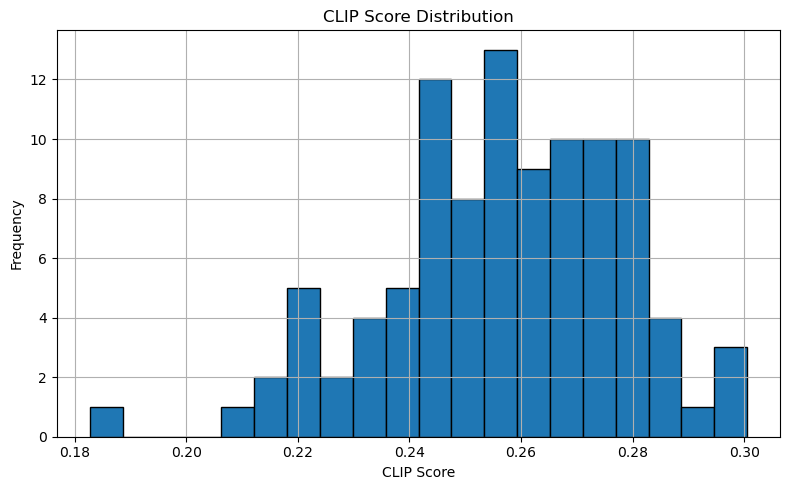

In [13]:
import matplotlib.pyplot as plt

# CLIP Score 분포 시각화
plt.figure(figsize=(8, 5))
plt.hist(clip_scores, bins=20, edgecolor='black')
plt.title("CLIP Score Distribution")
plt.xlabel("CLIP Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
len(clip_scores)

In [ ]:
test_svg = evaluate(model, tokenizer, "a cat with wings")
print(test_svg)
